# 気象予測データの一般的な可視化
気象庁のMeso-scale Ensemble Prediction System (MEPS)のGPVデータを利用し可視化を試みます。

基本的に簡単な可視化しか行っていませんが、これらをいかにかっこよく見せるかは私自身も結構悩んでいます。

何かご参考になれば幸いです。

**謝辞** 利用したデータは気象庁、気象業務支援センターから提供されたものです。ここに御礼申し上げます。

## MEPS概要
[MEPS](https://www.jma.go.jp/jma/kishou/books/nwpkaisetu/latest/1_7_6.pdf)は気象庁のメソスケールモデルです。メソスケールとは、水平2-2000 km 程度のスケールのことを言います。低気圧の発達や台風の予測、集中豪雨などの発生などが計算される、天気予報になくてはならないスケールとなっています。

気象庁はもともとMSM (Meso-scale Model)を長く運用しており、これを元に天気予報を行ってきましたが、2019年からこれに初期摂動などを与え複数の予測結果を得たものを、MEPSとしてリリースしました。MEPSではコントロール（Ctrl）の他に、20の予測が出力されます。これらの予測をそれぞれアンサンブルメンバーと言い、特にCtrlはMSMそのものとなっています。計21個の予測結果から、気象現象の発生を確率的に見ることが可能です。

リリースして間もないこともあり、これらのメンバーをどのように取り扱うのか（例えば算術平均すべきか加重平均すべきか、機械学習すべきか）、未だに検討の余地が多く残されています。

このドキュメントでは、MEPS GPVという気象業務支援センターから提供されているものを利用します。本来、MEPSそのもののデータは、NUSDASという形式で格納され、これらのデータはランベルト座標にマッピングされています。これは、そもそも物理モデルで計算するときにランベルト座標で解いているためです。MEPS GPVではこれらを等緯度等経度に変換などを行っています。さらに、我々はこれらをnetcdf形式に変換し、取り回しを良くしています（圧縮率は下がります）。

今後、本番データでもnetcdfで見ることが多いと思いますので、参考にしてください。

## MEPS GPV諸元
項目|内容
---|---
出力ステップ| 3時間間隔
出力ステップ数| 14 (現在時刻含む、最長で39時間先予測)
メンバー数|21
地上格子数 (緯度、経度)| (505, 481)
地上解像度（緯度、経度）| (0.05度×0.0625度)、大体5km×5km
気圧面水平格子数（緯度、経度）| (253, 241)
気圧面水平解像度| (0.1度×0.125度)
領域|北緯 22.4度-47.6度、東経 120度-150度
1日の予測回数（1日あたりのファイル数）| 4回 (00, 06, 12, 18UTC)

## データの次元
次元|説明
---|---
time|時間。最初の時間は予測時の時刻。そこから3時間おきに39時間先まで。
longitude| 経度
latitude| 経度
member| アンサンブルメンバー(-10 ~ +10, 0はCntl)
levels| 気圧面（気圧面データのみ）

## データへの基本的なアクセス方法
ファイル名に予測開始時刻が記載されています。また、データの中には予測対象の時刻が次元として入っています。
1. ファイル名で予測開始時刻を探す。
2. 予測先時間を指定し、予測対象時刻を参照する。

という流れです。

## 使用するパッケージ
[Xarray](https://docs.xarray.dev/en/stable/#)を利用します。気象データは多次元配列ではありますが、pandas.Dataframeのように気象データを扱うことができます。今年で10周年を迎えますが、流行り始めたのは最近の機械学習ブームに併せてだったと記憶しています。

## ディレクトリの構成
```text
├── Dockerfile
├── data <-- データを格納する。他の箇所を参照しても良い。適宜。
│   ├── meps_20220815_12_pall.nc <-- 金子が作成したnetcdfファイル（拡張子.nc）
│   └── meps_20220815_12_srf.nc
├── poetry.lock <-- poetryを使って環境構築している。
├── pyproject.toml <-- Python環境情報
└── work　<-- 作業ディレクトリ
    ├── save
    │   └── wind_speed.gif <-- welcome.ipynbを回していれば勝手に作られる。 
    └── welcome.ipynb <-- このファイル。
```
## 参考資料
- [令和4年度数値予報解説資料集](https://www.jma.go.jp/jma/kishou/books/nwpkaisetu/latest/1_7_6.pdf)
- [メソスケール気象予測の改善と防災気象情報の高度化に関する研究](https://www.mri-jma.go.jp/Research/evaluation/H28/assign_fy2016_1.html)
- [気象業務支援センター　MEPS](http://www.jmbsc.or.jp/jp/online/file/f-online10250.html)

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import cartopy.crs as ccrs

import datetime as dt

In [2]:
def data_path_generator(target_date, data_root, surf_or_pall="surf", verbose=True):
    """
    指定された日付、データルートディレクトリ、およびsurf/pallフラグに基づいてデータファイルのパスを構築する。

    Parameters:
    target_date (datetime):アクセスする必要のあるデータセットの日付。
    data_root (str):データセットが格納されているルートディレクトリ。
    surf_or_pall (str, optional):データの種類（surfまたはpallデータ）を指定。デフォルトは 'surf'。
    verbose (bool, optional):ファイルパスを標準出力するかどうか。デフォルトはTrue。

    Returns:
    str:生成されたデータセットへのファイルパス。
    """
    assert surf_or_pall in ["surf", "pall"], "surf_or_pall must be 'surf' or 'pall'."
    if surf_or_pall == "surf":
        surf_or_pall = "srf"
    else:
        surf_or_pall = "pall"
    dpath = f"{data_root}/meps_{target_date.strftime('%Y%m%d_%H')}_{surf_or_pall}.nc"
    print("Data path -->", dpath) if verbose else None
    return dpath

In [3]:
SPATH = "save"  # save root
DROOT = "../data"  # data path
target_date = dt.datetime(2022, 8, 15, 12, 0, 0)  # 予測開始時刻(UTC)
os.makedirs(SPATH, exist_ok=True)
NUM_MEMBERS = 21  # 21 members in the ensemble
CNTL_MEMBER = 0  # -10から10までのアンサンブルメンバーのうち、0番目のメンバーがコントロール(i.e. MSM)。

## 地上のデータの可視化
MEPSは地上データと大気のデータと分けて提供されています。それぞれのデータで格納されている変数も異なります。ここでは、我々の生活と直接関係のある、地上のデータの可視化を行いましょう。

### 格納されている変数とその内容
よく聞く名前の変数が入っています。注意すべきなのは、降水量と直達短波放射以外は、瞬間の値が格納されていますが、降水量は前3時間からの積算量、直達短波放射は前3時間からの平均値が格納されています。そのため、最初のステップ（予測時間0時間）には、値が入っていません。

Name| Description| Units | Remarks
---|---|---|---
PRMSL| 地上気圧 | Pa |
U10m| 10m風速（経度方向）| m/s|
V10m| 10m風速（緯度方向）| m/s|
Prcp| 降水量| mm/3h| 前3時間降水量
DSWRF| 下向短波放射フラックス| W/m^2 |Downward Short-Wave Radiation Fluxの単語の頭文字を取ったもので、日射量と同じです。

参考：[GRIB2 - CODE TABLE 4.2 PARAMETER NUMBER BY PRODUCT DISCIPLINE AND PARAMETER CATEGORY](https://www.nco.ncep.noaa.gov/pmb/docs/grib2/grib2_doc/grib2_table4-2.shtml) GRIB2形式（変換前のファイル）の変数名のリスト。

In [4]:
dpath = data_path_generator(target_date, DROOT, "surf")
ds = xr.open_dataset(dpath)
ds

Data path --> ../data/meps_20220815_12_srf.nc


<xarray.Dataset>
Dimensions:    (time: 14, longitude: 481, latitude: 505, member: 21)
Coordinates:
  * time       (time) datetime64[ns] 2022-08-15T12:00:00 ... 2022-08-17T03:00:00
  * longitude  (longitude) float64 120.0 120.1 120.1 120.2 ... 149.9 149.9 150.0
  * latitude   (latitude) float64 22.4 22.45 22.5 22.55 ... 47.5 47.55 47.6
  * member     (member) int32 -10 -9 -8 -7 -6 -5 -4 -3 -2 ... 2 3 4 5 6 7 8 9 10
Data variables:
    prmsl      (member, time, latitude, longitude) float32 ...
    u10m       (member, time, latitude, longitude) float32 ...
    v10m       (member, time, latitude, longitude) float32 ...
    t2m        (member, time, latitude, longitude) float32 ...
    prcp       (member, time, latitude, longitude) float32 ...
    dswrf      (member, time, latitude, longitude) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 2.3.0 (https://mpime...
    Conventions:          COARDS
    History:              Tue Dec 26 11:19:42 2023: ncap2 -s member[$member]=...
    GRIB2_grid_template:  0
    history:              Tue Dec 26 11:19:35 2023: cdo mergetime ./tmp/MEPS_...
    CDO:                  Climate Data Operators version 2.3.0 (https://mpime...
    NCO:                  netCDF Operators version 4.8.1 (Homepage = http://n...

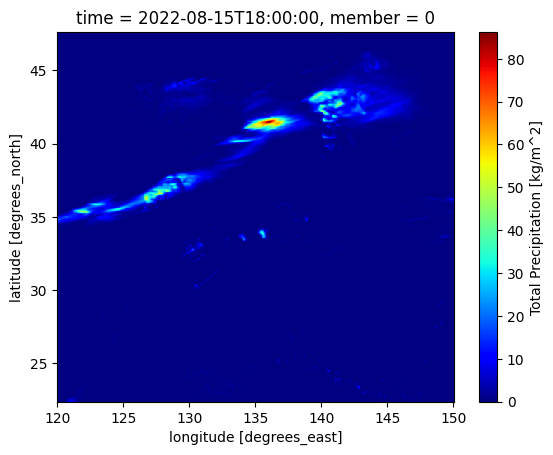

In [5]:
# quick plot
lead_time = dt.timedelta(hours=6)  # 予測先時間
forecast_time = target_date + lead_time  # 予測対象日時
ds["prcp"].sel(time=forecast_time, member=0).plot(cmap="jet")

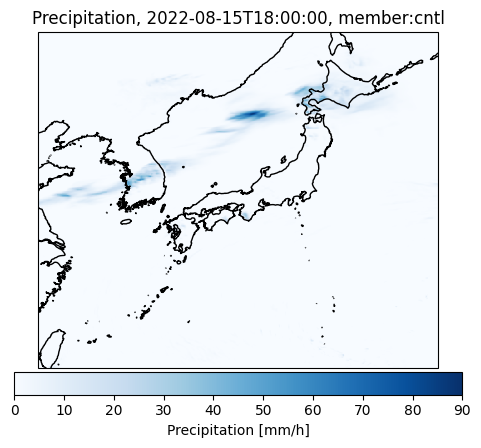

In [6]:
"""
**注意**こ のグラフの単位は間違っています。[mm/3h]か[mm]が正しいです。

前の図では日本がどこかわかりませんので、地図を描画してみます。
cartopyを使って海岸線を描画します。
データの抽出はselやiselを使って行います。Pandasで言う所のlocやilocです。
"""

lead_time = dt.timedelta(hours=6)  # 予測先時間
forecast_time = target_date + lead_time  # 予測対象日時
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes(
    [0.1, 0.1, 0.8, 0.8],
    projection=ccrs.PlateCarree(),
)  # 図法の定義
cax = (
    ds["prcp"]
    .sel(
        time=forecast_time,
        member=0,
    )
    .plot(
        cmap="Blues",
        add_colorbar=False,
        vmin=0,
        vmax=90,
        ax=ax,
    )
)  # データをselで抽出しプロット。
cbar = plt.colorbar(
    cax,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.7,
)
cbar.set_label("Precipitation [mm/h]")
ax.coastlines(color="k", resolution="10m")  # 海岸線の描画
ax.set_title("Precipitation, 2022-08-15T18:00:00, member:cntl")
plt.show()

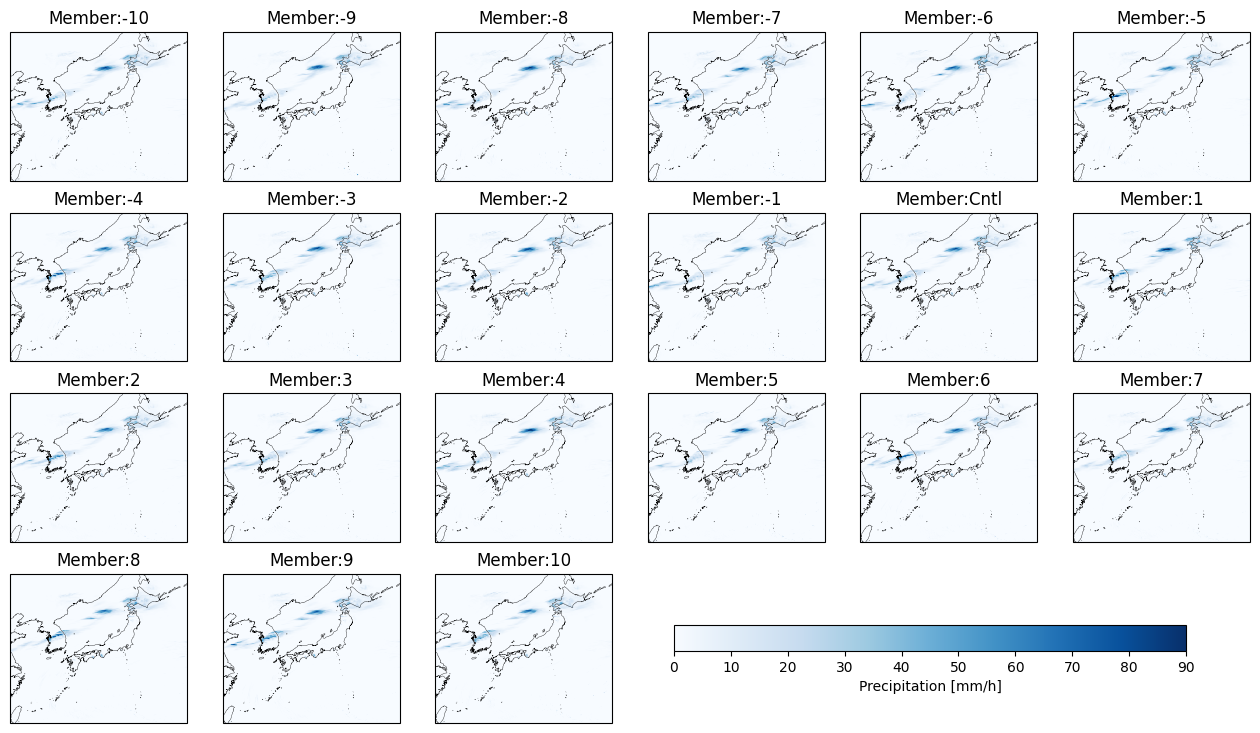

In [7]:
"""
**注意**こ のグラフの単位は間違っています。[mm/3h]か[mm]が正しいです。

全てのメンバーを可視化します。
皆ちょっとずつ出力が異なっていることがわかります。
"""

lead_time = dt.timedelta(hours=6)  # 予測先時間
forecast_time = target_date + lead_time  # 予測対象日時
fig = plt.figure(figsize=(16, 9))
for i in range(NUM_MEMBERS):
    ax = fig.add_subplot(
        4,
        6,
        i + 1,
        projection=ccrs.PlateCarree(),
    )
    im = (
        ds["prcp"]
        .sel(
            time=forecast_time,
            member=i - 10,
        )
        .plot(
            cmap="Blues",
            add_colorbar=False,
            vmin=0,
            vmax=90,
            ax=ax,
        )
    )
    ax.coastlines(color="k", resolution="10m", linewidth=0.25)
    ax.set_title(
        f"Member:{i-10}" if (i - 10) != CNTL_MEMBER else "Member:Cntl",
    )

ax = fig.add_axes([0.5, 0.1, 0.4, 0.8])

ax.axis("off")
cbar = plt.colorbar(
    im,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
)
cbar.set_label("Precipitation [mm/h]")

plt.show()

In [8]:
uv = (ds["u10m"] ** 2 + ds["v10m"] ** 2) ** 0.5  # ＵとＶの合成風速をプロットのために計算します。
ds["uv"] = uv

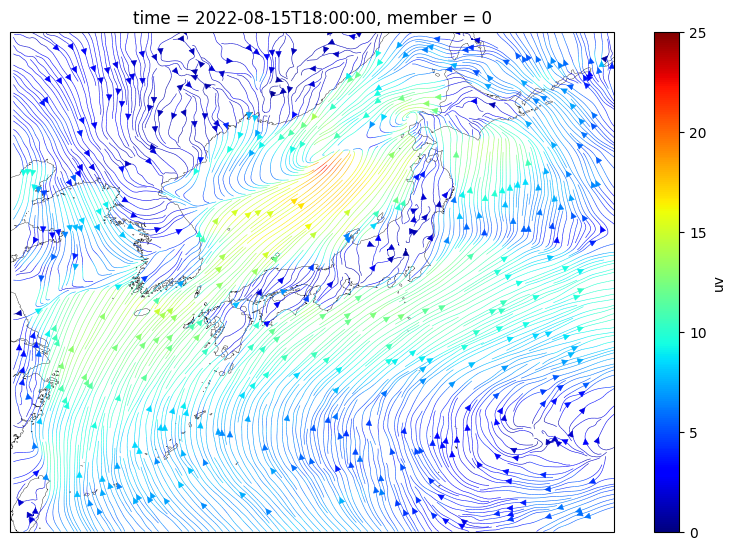

In [9]:
"""
流れの線を描画します。
北海道の南側にある低気圧より南側では、南から北へ強い風が流れていることがわかります。
また、低気圧の中心から朝鮮半島に掛けて前線が確認出来ます。
https://tenki.jp/past/2022/08/16/chart/
"""

lead_time = dt.timedelta(hours=6)  # 予測先時間
forecast_time = target_date + lead_time  # 予測対象日時

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes(
    [0, 0, 1, 1],
    projection=ccrs.PlateCarree(),
)
ax.set_extent([120, 150, 22.5, 46.5])
ds.sel(
    time=forecast_time,
    member=0,
).plot.streamplot(
    x="longitude",
    y="latitude",
    u="u10m",
    v="v10m",
    hue="uv",
    density=6,
    linewidth=0.4,
    ax=ax,
    cmap="jet",
    vmin=0,
    vmax=25,
)
ax.coastlines(color="k", resolution="10m", linewidth=0.25)

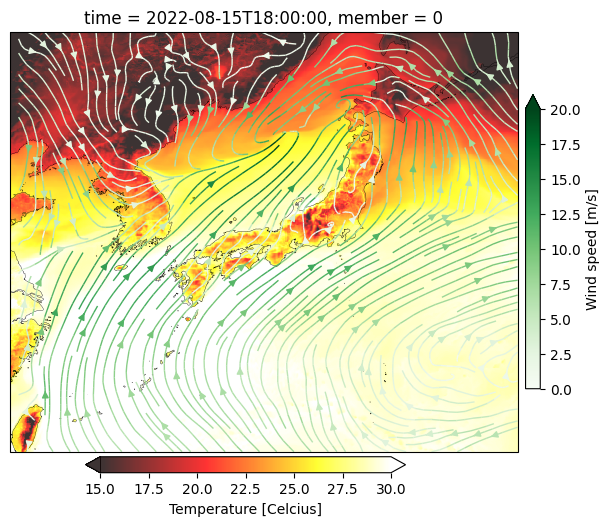

In [10]:
"""
気温を可視化することで、前線を確認してみます。
確かに、前線の前後でハッキリとした気温の差が確認出来ます。
"""

lead_time = dt.timedelta(hours=6)  # 予測先時間
forecast_time = target_date + lead_time  # 予測対象日時

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes(
    [0, 0, 1, 1],
    projection=ccrs.PlateCarree(),
)
ax.set_extent([120, 150, 22.5, 46.5])
cax_uv = ds.sel(
    time=forecast_time,
    member=0,
).plot.streamplot(
    x="longitude",
    y="latitude",
    u="u10m",
    v="v10m",
    hue="uv",
    density=2,
    linewidth=1,
    ax=ax,
    cmap="Greens",
    vmin=0,
    vmax=20,
    add_guide=False,
)
cax_temp = (
    ds["t2m"].sel(
        time=forecast_time,
        member=0,
    )
    - 273.15
).plot(
    cmap="hot",
    add_colorbar=False,
    vmin=15,
    vmax=30,
    ax=ax,
    alpha=0.8,
)
cbar_temp = plt.colorbar(
    cax_temp,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.4,
    extend="both",
)
cbar_uv = plt.colorbar(
    cax_uv,
    ax=ax,
    orientation="vertical",
    pad=0.01,
    shrink=0.7,
    extend="max",
)
cbar_temp.set_label("Temperature [Celcius]")
cbar_uv.set_label("Wind speed [m/s]")


ax.coastlines(color="k", resolution="10m", linewidth=0.25)

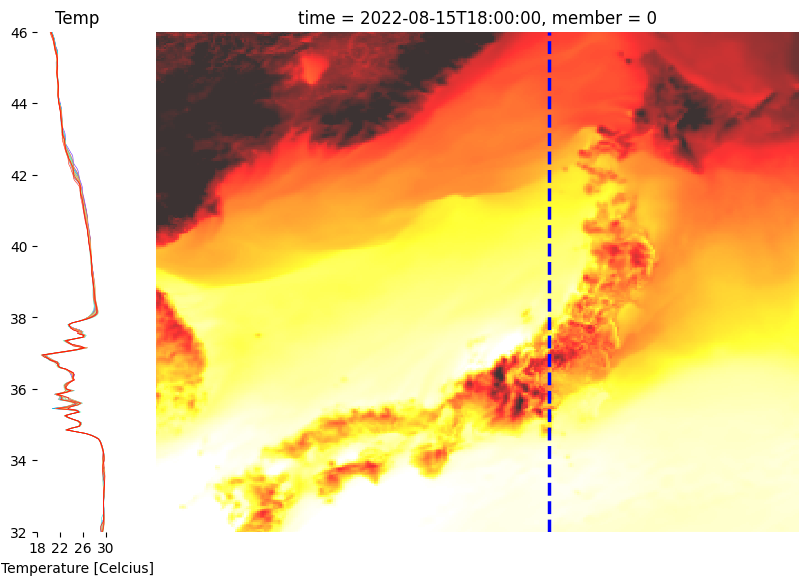

In [11]:
"""
更に、緯度方向に切り出して気温の勾配を確認します。
図中青点線の緯度で切り出しています。
確かに、北緯42度付近で、3度から4度ほどの急激な気温の変化が確認出来ます。
※あんまり厳密じゃない図なので、左と右のaxisの縦と横はキチンと揃えた方が良いかも。
"""

lead_time = dt.timedelta(hours=6)  # 予測先時間
forecast_time = target_date + lead_time  # 予測対象日時

extract_lon = 139

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 0.1, 1], frameon=False)
colors = plt.cm.rainbow(np.linspace(0, 1, NUM_MEMBERS))
ds_tmp = ds["t2m"].sel(
    time=forecast_time,
    longitude=extract_lon,
    method="nearest",
)

for m in range(NUM_MEMBERS):
    ax.plot(
        (ds_tmp.sel(member=m - 10) - 273.15),
        ds_tmp["latitude"],
        color=colors[m],
        linewidth=0.4,
    )
ax.set_xlabel("Temperature [Celcius]")
plt.ylim(32, 46)
plt.xlim(18, 32)
ax.set_xticks(np.arange(18, 34, 4))
plt.title("Temp")

ax = fig.add_axes(
    [0.11, 0, 0.88, 1],
    projection=ccrs.PlateCarree(),
    frameon=False,
)
ax.set_extent([128, 146, 32, 46])
cax_temp = (
    ds["t2m"].sel(
        time=forecast_time,
        member=0,
    )
    - 273.15
).plot(
    cmap="hot",
    add_colorbar=False,
    vmin=15,
    vmax=30,
    ax=ax,
    alpha=0.8,
)
ax.vlines(
    extract_lon,
    32,
    46,
    color="blue",
    linewidth=2.5,
    linestyle="--",
)

In [12]:
ds.close()

## 気圧面データ

## 気圧面データの可視化
地上面と可視化の方法は大きく変わりません。3次元データなので本来3次元の可視化をしたいのですが、鉛直面が僅か6層もないので、3D可視化はうーんといった感じです。

### 格納されている変数とその内容

Name| Description| Units | Remarks
---|---|---|---
UGRD| 風速（経度方向） | m/s |
VGRD| 風速（緯度方向）| m/s|
TMP| 気温| K|
RH| 相対湿度| %|
HGT| ジオポテンシャル高度| m |


### 格納されている気圧面
通報面 | 高度(HGT) | 風(UGRD, VGRD) | 気温(TMP) | 相対湿度(RH)
---: | :---: | :---: | :---: | :---:
975hPa|     | 2 | O   |
950hPa|     | 2 | O   |
925hPa|     | 2 | O   | O
850hPa|     | 2 | O   | O
500hPa| O   |   | O   | O
300hPa| O   | 2 |     |

- 表中「O」は各通報面に含まれる要素を示す。
- 表中「2」は２要素分のデータ（風の場合，東西方向と南北方向の２要素）が含まれ ることを示す。

In [4]:
dpath = data_path_generator(target_date, DROOT, "pall")

ds = xr.open_dataset(dpath)
ds

Data path --> ../data/meps_20220815_12_pall.nc


<xarray.Dataset>
Dimensions:    (time: 14, longitude: 241, latitude: 253, levels: 6, member: 21)
Coordinates:
  * time       (time) datetime64[ns] 2022-08-15T12:00:00 ... 2022-08-17T03:00:00
  * longitude  (longitude) float64 120.0 120.1 120.2 120.4 ... 149.8 149.9 150.0
  * latitude   (latitude) float64 22.4 22.5 22.6 22.7 ... 47.3 47.4 47.5 47.6
  * levels     (levels) float32 975.0 950.0 925.0 850.0 500.0 300.0
  * member     (member) int32 -10 -9 -8 -7 -6 -5 -4 -3 -2 ... 2 3 4 5 6 7 8 9 10
Data variables:
    UGRD       (member, time, levels, latitude, longitude) float32 ...
    VGRD       (member, time, levels, latitude, longitude) float32 ...
    TMP        (member, time, levels, latitude, longitude) float32 ...
    RH         (member, time, levels, latitude, longitude) float32 ...
    HGT        (member, time, levels, latitude, longitude) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 2.3.0 (https://mpime...
    Conventions:          COARDS
    History:              Tue Dec 26 11:19:39 2023: ncap2 -s member[$member]=...
    GRIB2_grid_template:  0
    history:              Tue Dec 26 11:19:33 2023: cdo mergetime ./tmp/MEPS_...
    CDO:                  Climate Data Operators version 2.3.0 (https://mpime...
    NCO:                  netCDF Operators version 4.8.1 (Homepage = http://n...

In [14]:
uv = (ds["UGRD"] ** 2 + ds["VGRD"] ** 2) ** 0.5
ds["uv"] = uv

In [15]:
lev = 850  # 気圧面
member = 0  # メンバー


forecast_times = ds["time"].values
init_time = forecast_times[0]


fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes(
    [0.05, 0.05, 0.9, 0.88],
    projection=ccrs.PlateCarree(),
)
ax.set_extent([120, 150, 22.5, 46.5])
ax.coastlines(
    color="w",
    resolution="10m",
    linewidth=0.75,
)


def anim_init():
    pass


def animate(ctime):
    cax = (
        ds["uv"]
        .sel(
            time=ctime,
            levels=lev,
            member=member,
        )
        .plot(
            cmap="jet",
            vmin=0,
            vmax=40,
            ax=ax,
            add_colorbar=False,
        )
    )

    lead_time = pd.to_datetime(ctime) - pd.to_datetime(init_time)

    if ctime == init_time:
        cbar = plt.colorbar(cax)
        cbar.set_label("Wind speed [m/s]")

    ax.set_title(
        f'Time:{pd.to_datetime(ctime).strftime("%Y-%m-%d %H:%M:%S")}, ' f" LeadTime:{lead_time}\nMember:{member},lev: {lev} hPa",
    )


ani = animation.FuncAnimation(
    fig,
    animate,
    frames=forecast_times,
    init_func=anim_init,
    interval=400,
    repeat_delay=1000,
)
ani.save(f"{SPATH}/wind_speed.gif", writer="pillow")
plt.close()

[](save / wind_speed.gif)

以下の様な出力を得られる。

![wind speed](save/wind_speed.gif)

### ジオポテンシャル高度と幾何高度

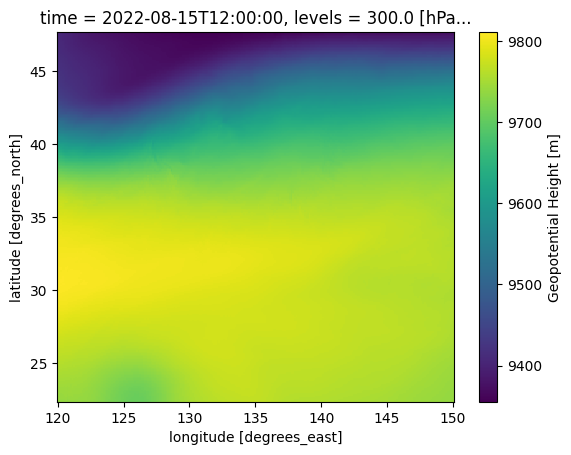

In [12]:
ds["HGT"].sel(time="2022-08-15T12:00:00", member=0, levels=300).plot()

In [16]:
ds.close()

# 可視化に関して参考になりそうなサイト
今回はXarrayを利用しましたが、気象データの可視化には色々なツールがあります。
- [CliMetLab](https://climetlab.readthedocs.io/en/latest/#) <--最近はやりです
- [Panoply](https://www.giss.nasa.gov/tools/panoply/)
- [Ncview](https://cirrus.ucsd.edu/ncview/)
